In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
print("Bibliotheken erfolgreich geladen!")

Bibliotheken erfolgreich geladen!


In [7]:
# 1. DatenVorbereitung

# Daten laden
df = pd.read_csv('../data/raw/OnlineRetail.csv', encoding='ISO-8859-1')

# Ersten Blick auf Daten
print("Datensatz Übersicht:")
print(f"Wir haben {df.shape[0]} Zeilen, und {df.shape[1]} Spalten")
print("\nErste 5 Zeilen:")
print(df.head())
print("\nDatentypen:")
print(df.dtypes)
print("\nStatistische Überblick:")
print(df.describe())
print("\nFehlende Werte:")
print(df.isnull().sum())

Datensatz Übersicht:
Wir haben 541909 Zeilen, und 8 Spalten

Erste 5 Zeilen:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Datentypen:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPric

In [8]:
# Datenbereinigung
print("\nDatenbereinigung startet....")

# 1. Fehlende CustomerID entfernen
df_clean = df[df['CustomerID'].notna()].copy()
print(f"\nNach Entfernung fehlender CustomerID: {df_clean.shape[0]} Zeilen")

# 2.Negative Mengen und Preise entfernen
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f"\nNach Entfernung negative Werte: {df_clean.shape[0]} Zeilen")

# Duplikate entfernen
df_clean = df_clean.drop_duplicates()
print(f"Nach Entfernung Duplikate: {df_clean.shape[0]} Zeilen")

# 3. InvoiceDate in Datetime konvertieren
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# 4. Gesamtbetrag berechnen 
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
print("\nDatenbereinigung abgeschlossen!")
print(f"Finale Daten: {df_clean.shape}")
print(f"Anzahl Kunden: {df_clean['CustomerID'].nunique()}")


Datenbereinigung startet....

Nach Entfernung fehlender CustomerID: 406829 Zeilen

Nach Entfernung negative Werte: 397884 Zeilen
Nach Entfernung Duplikate: 392692 Zeilen

Datenbereinigung abgeschlossen!
Finale Daten: (392692, 9)
Anzahl Kunden: 4338


In [9]:
# RFM-Analyse erstellen
print("=" * 50)
print("Feature Engineering: RFM-Analyse")
print("=" * 50)

# Referenzdatum berechnen( 1 Tag nach dem letzten Kauf im Datensatz)
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Referenzdatum: {snapshot_date}")

# RFM pro Kunde berechnen
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x : (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Ergebnisse
print(f"\nRFM-Features erstellt für {len(rfm)} Kunden")
print("\nErste 10 Kunden")
print(rfm.head(10))
print("\nRFM Statistiken:")
print(rfm.describe())

# Prüfen auf problematische Werte
print(f"Fehlende Werte: {rfm.isnull().sum().sum()}")
print(f"Negative Werte in Recency: {(rfm['Recency'] < 0).sum()}")
print(f"Null-Werte in Frequency: {(rfm['Frequency'] == 0).sum()}")
print(f"Null-Werte in Monetary: {(rfm['Monetary'] <= 0).sum()}")

Feature Engineering: RFM-Analyse
Referenzdatum: 2011-12-10 12:50:00

RFM-Features erstellt für 4338 Kunden

Erste 10 Kunden
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40
5     12352.0       36          8   2506.04
6     12353.0      204          1     89.00
7     12354.0      232          1   1079.40
8     12355.0      214          1    459.40
9     12356.0       23          3   2811.43

RFM Statistiken:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2048.688081
std     1721.808492   100.014169     7.697998    8985.230220
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     306.482500
50%    1

Explorative Datenanalyse (EDA)


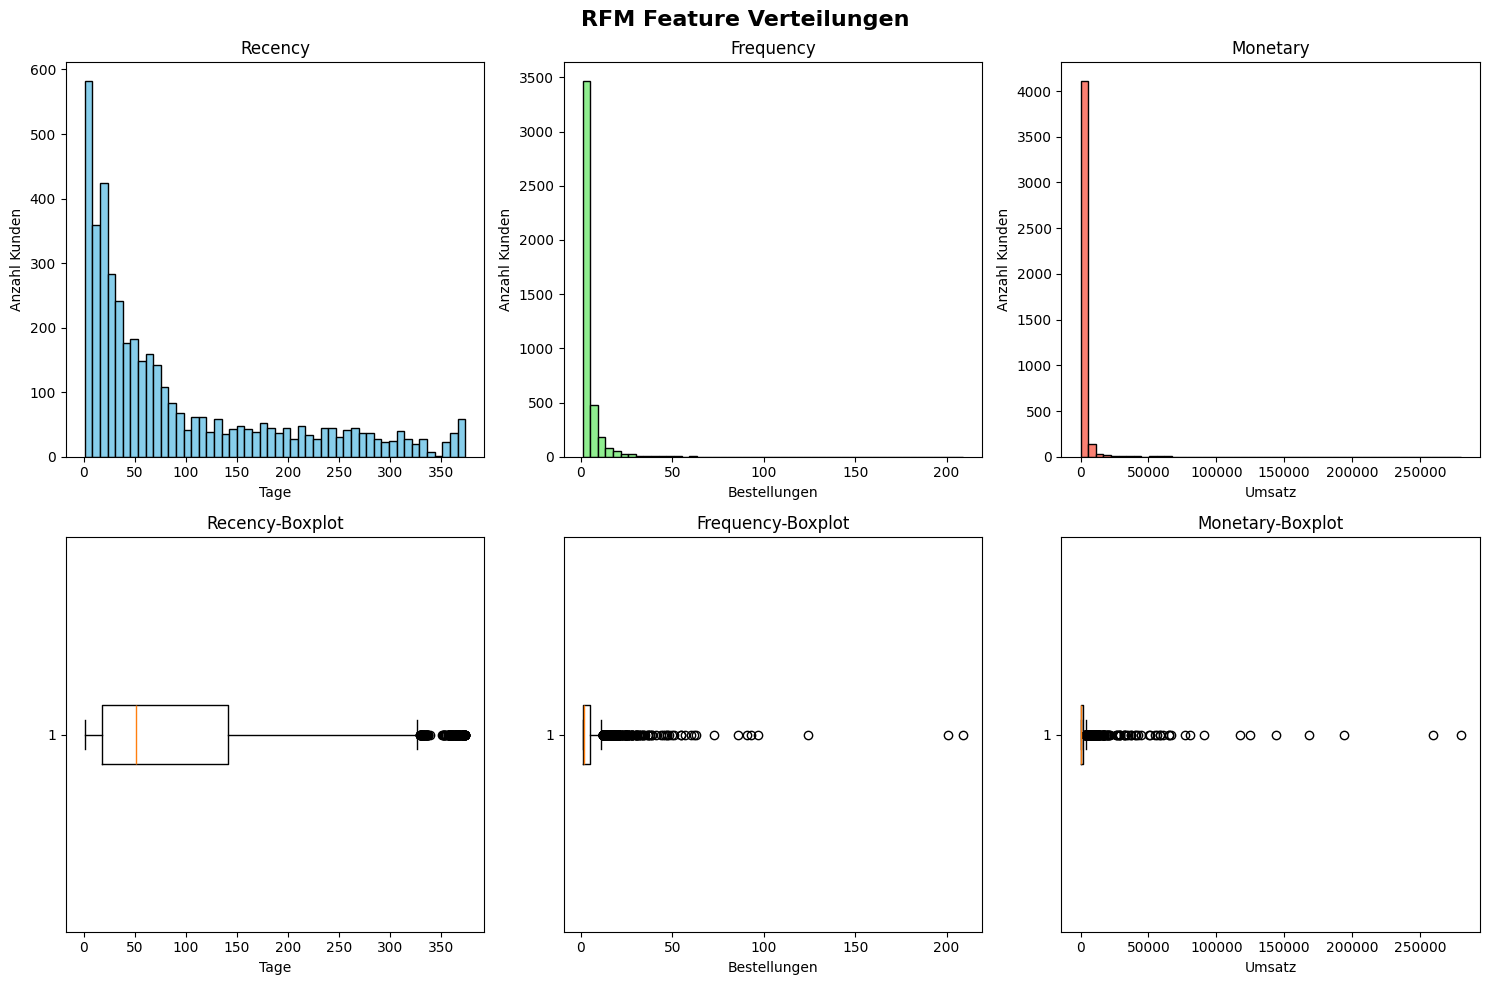


Ausreißer-Analyse

Recency:
 - 95% der Kunden: <= 312 Tage
 - Maximum: 374 Tage

Frequency:
 - 95% der Kunden: <= 13 Bestellungen
 - Maximum: 209 Bestellungen

Monetary:
 - 95% der Kunden: <= 5790.00
 - Maximum: 280206.02

Erkenntnis: Die sind stark rechtsschief!
  -> Wir brauchen Log-Transformation + Skalierung


In [10]:
# EDA: Verteilung visualisieren
print("=" * 50)
print("Explorative Datenanalyse (EDA)")
print("=" * 50)

# Figure mit Subplots erstellen
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('RFM Feature Verteilungen', fontsize=16, fontweight='bold')

# Original-Verteilungen (links)
axes[0, 0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Recency') # Tage seit letztem Kuaf
axes[0, 0].set_xlabel('Tage')
axes[0, 0].set_ylabel('Anzahl Kunden')

axes[0, 1].hist(rfm['Frequency'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Frequency') # Anzahl Bestellungen
axes[0, 1].set_xlabel('Bestellungen')
axes[0, 1].set_ylabel('Anzahl Kunden')

axes[0, 2].hist(rfm['Monetary'], bins=50, color='salmon', edgecolor='black')
axes[0, 2].set_title('Monetary') # Gesamtumsatz
axes[0, 2].set_xlabel('Umsatz')
axes[0, 2].set_ylabel('Anzahl Kunden')

# Boxplots - zeigen Ausreißer
axes[1, 0].boxplot(rfm['Recency'], vert=False)
axes[1, 0].set_title('Recency-Boxplot')
axes[1, 0].set_xlabel('Tage')

axes[1, 1].boxplot(rfm['Frequency'], vert=False)
axes[1, 1].set_title('Frequency-Boxplot')
axes[1, 1].set_xlabel('Bestellungen')

axes[1, 2].boxplot(rfm['Monetary'], vert=False)
axes[1, 2].set_title('Monetary-Boxplot')
axes[1, 2].set_xlabel('Umsatz')

plt.tight_layout()
plt.show()

# Statistische Kennzahlen für Ausreißer
print("\nAusreißer-Analyse")
print("\nRecency:")
print(f" - 95% der Kunden: <= {rfm['Recency'].quantile(0.95):.0f} Tage")
print(f" - Maximum: {rfm['Recency'].max():.0f} Tage")

print("\nFrequency:")
print(f" - 95% der Kunden: <= {rfm['Frequency'].quantile(0.95):.0f} Bestellungen")
print(f" - Maximum: {rfm['Frequency'].max():.0f} Bestellungen")

print("\nMonetary:")
print(f" - 95% der Kunden: <= {rfm['Monetary'].quantile(0.95):.2f}")
print(f" - Maximum: {rfm['Monetary'].max():.2f}")

print("\nErkenntnis: Die sind stark rechtsschief!")
print("  -> Wir brauchen Log-Transformation + Skalierung")


In [11]:
# Transformation & Skalierung
print("=" * 50)
print("Transformation & Skalierung")
print("=" * 50)

# Vorbereitung: Features extrahieren (Ohne CustomerID)
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']].copy()
print("Schritt 1: Log-Transformation")
print("-" * 50)
# Log1p = log(1+x) -> vermeidet log(0)
rfm_log = np.log1p(rfm_features)
print("Original vs. Log-transformiert:")
print("\nOriginal:")
print(rfm_features.describe())
print("\nNach Log-Transformationen:")
print(rfm_log.describe())

print("\n" + "=" * 50)
print("Schritt 2: StandardScaler anwenden")
print("=" * 50)

# StandardScaler: (x - mean) / std -> mean=0, std=1
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# Als DataFrame
rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
)
print("Nach Skalierung (sollte ~0 mean, ~1 std haben):\n")
print(rfm_scaled_df.describe())

Transformation & Skalierung
Schritt 1: Log-Transformation
--------------------------------------------------
Original vs. Log-transformiert:

Original:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2048.688081
std     100.014169     7.697998    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     306.482500
50%      51.000000     2.000000     668.570000
75%     142.000000     5.000000    1660.597500
max     374.000000   209.000000  280206.020000

Nach Log-Transformationen:
           Recency    Frequency     Monetary
count  4338.000000  4338.000000  4338.000000
mean      3.830734     1.345582     6.588562
std       1.340261     0.683104     1.258438
min       0.693147     0.693147     1.558145
25%       2.944439     0.693147     5.728418
50%       3.951244     1.098612     6.506636
75%       4.962845     1.791759     7.415535
max       5.926926     5.347108    12

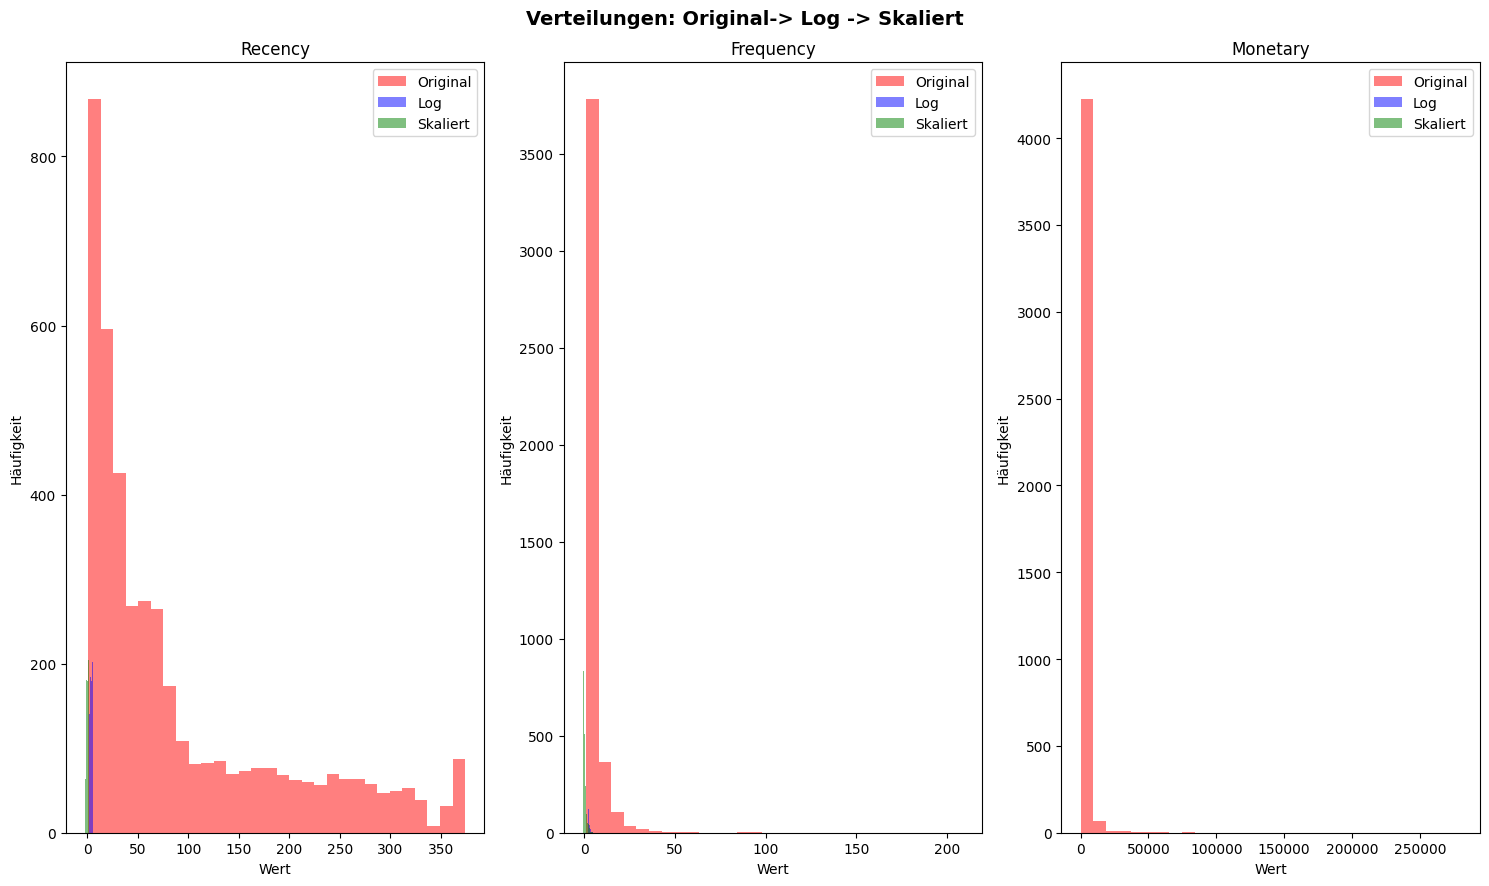

In [12]:
# Visualisierung: Vorher vs. Nachher
fig, axes = plt.subplots(1, 3, figsize=(15,9))
fig.suptitle('Verteilungen: Original-> Log -> Skaliert', fontsize=14, fontweight='bold')
features = ['Recency', 'Frequency', 'Monetary']
for idx, feature in enumerate(features):
    # Original
    axes[idx].hist(rfm_features[feature], bins=30, alpha=0.5, label='Original', color='red')
    # Log-transformiert
    axes[idx].hist(rfm_log[feature], bins=30, alpha=0.5, label='Log', color='blue')
    # Skaliert
    axes[idx].hist(rfm_scaled_df[f'{feature}_scaled'], bins=30, alpha=0.5, label='Skaliert', color='green')

    axes[idx].set_title(feature)
    axes[idx].legend()
    axes[idx].set_xlabel('Wert')
    axes[idx].set_ylabel('Häufigkeit')
plt.tight_layout()
plt.show()

In [13]:
# 2. Clustering-Algorithmen
# K-Means, HAC, DBSCAN, OPTICS

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS

# Metriken zur Evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

# Für HAC Dendrogramm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Warnings unterdrücken
import warnings
warnings.filterwarnings('ignore')

print("Alle Libraries erfolgreich importiert!")

Alle Libraries erfolgreich importiert!


In [14]:
print("="*60)
print("K-MEANS: Optimale Cluster-Anzahl bestimmen")
print("="*60)

# Bereich testen: 2 bis 10 Cluster
k_range = range(2, 11)
wcss = []  # Within-Cluster Sum of Squares (Elbow-Methode)
silhouette_scores = []

for k in k_range:
    # K-Means mit k Clustern
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    
    # WCSS berechnen (Inertia)
    wcss.append(kmeans.inertia_)
    
    # Silhouette Score berechnen
    labels = kmeans.labels_
    silhouette = silhouette_score(rfm_scaled_df, labels)
    silhouette_scores.append(silhouette)
    
    print(f"k={k}: WCSS={kmeans.inertia_:.2f}, Silhouette={silhouette:.4f}")

print("\nK-Means Evaluation abgeschlossen!")

K-MEANS: Optimale Cluster-Anzahl bestimmen
k=2: WCSS=6483.59, Silhouette=0.4328
k=3: WCSS=4869.49, Silhouette=0.3365
k=4: WCSS=3939.05, Silhouette=0.3375
k=5: WCSS=3296.71, Silhouette=0.3162
k=6: WCSS=2855.76, Silhouette=0.3124
k=7: WCSS=2548.82, Silhouette=0.3092
k=8: WCSS=2336.34, Silhouette=0.3033
k=9: WCSS=2156.01, Silhouette=0.2811
k=10: WCSS=2005.75, Silhouette=0.2767

K-Means Evaluation abgeschlossen!


Plot gespeichert: ../results/figures1/kmeans_optimal_k.png


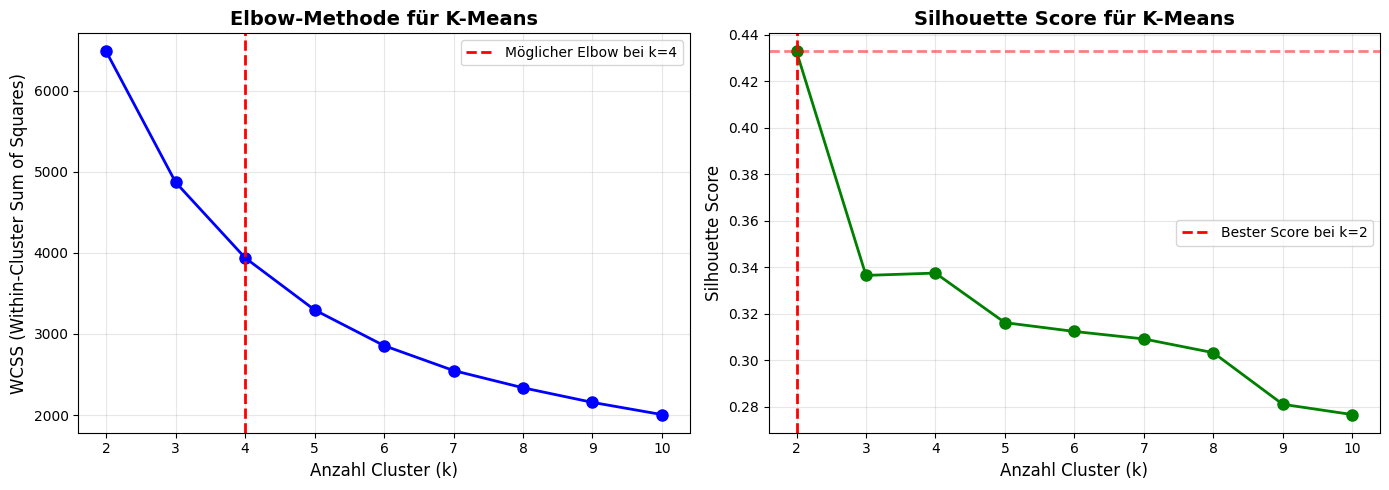


EMPFEHLUNG für K-Means:
Bester Silhouette Score: k=2 (Score=0.4328)
Elbow-Methode deutet auf: k=3 oder k=4

Wähle Cluster-Anzahl: k=4


In [15]:
# Visualisierung: Elbow-Methode und Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Elbow-Methode (WCSS)
axes[0].plot(k_range, wcss, marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Anzahl Cluster (k)', fontsize=12)
axes[0].set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow-Methode für K-Means', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axvline(x=4, color='red', linestyle='--', linewidth=2, label='Möglicher Elbow bei k=4')
axes[0].legend()

# Plot 2: Silhouette Score
axes[1].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Anzahl Cluster (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score für K-Means', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axhline(y=max(silhouette_scores), color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].axvline(x=k_range[silhouette_scores.index(max(silhouette_scores))], 
                color='red', linestyle='--', linewidth=2, 
                label=f'Bester Score bei k={k_range[silhouette_scores.index(max(silhouette_scores))]}')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/figures1/kmeans_optimal_k.png', dpi=300, bbox_inches='tight')
print("Plot gespeichert: ../results/figures1/kmeans_optimal_k.png")
plt.show()

# Meine Empfehlung 
best_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]
print("\n" + "="*60)
print("EMPFEHLUNG für K-Means:")
print("="*60)
print(f"Bester Silhouette Score: k={best_k_silhouette} (Score={max(silhouette_scores):.4f})")
print(f"Elbow-Methode deutet auf: k=3 oder k=4")
print(f"\nWähle Cluster-Anzahl: k=4")
print("="*60)

In [16]:
print("="*60)
print("K-MEANS: Finales Modell mit k=4")
print("="*60)

# K-Means mit k=4 trainieren
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(rfm_scaled_df)

# Labels zum DataFrame hinzufügen
rfm_scaled_df['KMeans_Cluster'] = kmeans_labels

# Auch zu den Original-RFM-Daten hinzufügen
rfm['KMeans_Cluster'] = kmeans_labels

print(f"K-Means Clustering abgeschlossen!")
print(f"\nCluster-Verteilung:")
print(rfm['KMeans_Cluster'].value_counts().sort_index())

# RFM-Profile der K-Means Cluster
print("\n" + "="*60)
print("RFM-Profile der K-Means Cluster:")
print("="*60)
kmeans_profile = rfm.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
kmeans_profile['Anzahl_Kunden'] = rfm['KMeans_Cluster'].value_counts().sort_index()
print(kmeans_profile.round(2))

# Evaluation
silhouette_kmeans = silhouette_score(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], kmeans_labels)

print("\n" + "="*60)
print("K-Means Evaluation Metriken:")
print("="*60)
print(f"Silhouette Score: {silhouette_kmeans:.4f} (höher = besser, -1 bis +1)")
print(f"Davies-Bouldin Index: {davies_bouldin_kmeans:.4f} (niedriger = besser)")
print("="*60)

K-MEANS: Finales Modell mit k=4
K-Means Clustering abgeschlossen!

Cluster-Verteilung:
KMeans_Cluster
0     713
1    1622
2     837
3    1166
Name: count, dtype: int64

RFM-Profile der K-Means Cluster:
                Recency  Frequency  Monetary  Anzahl_Kunden
KMeans_Cluster                                             
0                 12.17      13.75   8088.02            713
1                181.51       1.32    341.00           1622
2                 17.70       2.19    557.32            837
3                 71.64       4.08   1801.78           1166

K-Means Evaluation Metriken:
Silhouette Score: 0.3375 (höher = besser, -1 bis +1)
Davies-Bouldin Index: 1.0086 (niedriger = besser)


In [17]:
print("="*60)
print("HAC: Hierarchical Agglomerative Clustering")
print("="*60)

print("="*60)
print("HAC: Linkage-Matrix berechnen")
print("="*60)

# Linkage-Matrix mit Ward-Methode berechnen
linkage_matrix = linkage(
    rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], 
    method='ward'
)

print("Linkage-Matrix berechnet!")
print(f"Form der Linkage-Matrix: {linkage_matrix.shape}")
print(f"\nErste 5 Zeilen:")
print(linkage_matrix[:5])

HAC: Hierarchical Agglomerative Clustering
HAC: Linkage-Matrix berechnen
Linkage-Matrix berechnet!
Form der Linkage-Matrix: (4337, 4)

Erste 5 Zeilen:
[[3.46900000e+03 3.95800000e+03 8.26105800e-05 2.00000000e+00]
 [7.23000000e+02 4.24700000e+03 3.72657990e-04 2.00000000e+00]
 [2.63400000e+03 3.38400000e+03 4.18527982e-04 2.00000000e+00]
 [1.51700000e+03 2.06100000e+03 4.83974761e-04 2.00000000e+00]
 [1.48000000e+03 3.60700000e+03 6.77761587e-04 2.00000000e+00]]


Dendrogramm gespeichert: ../results/figures1/hac_dendrogram.png


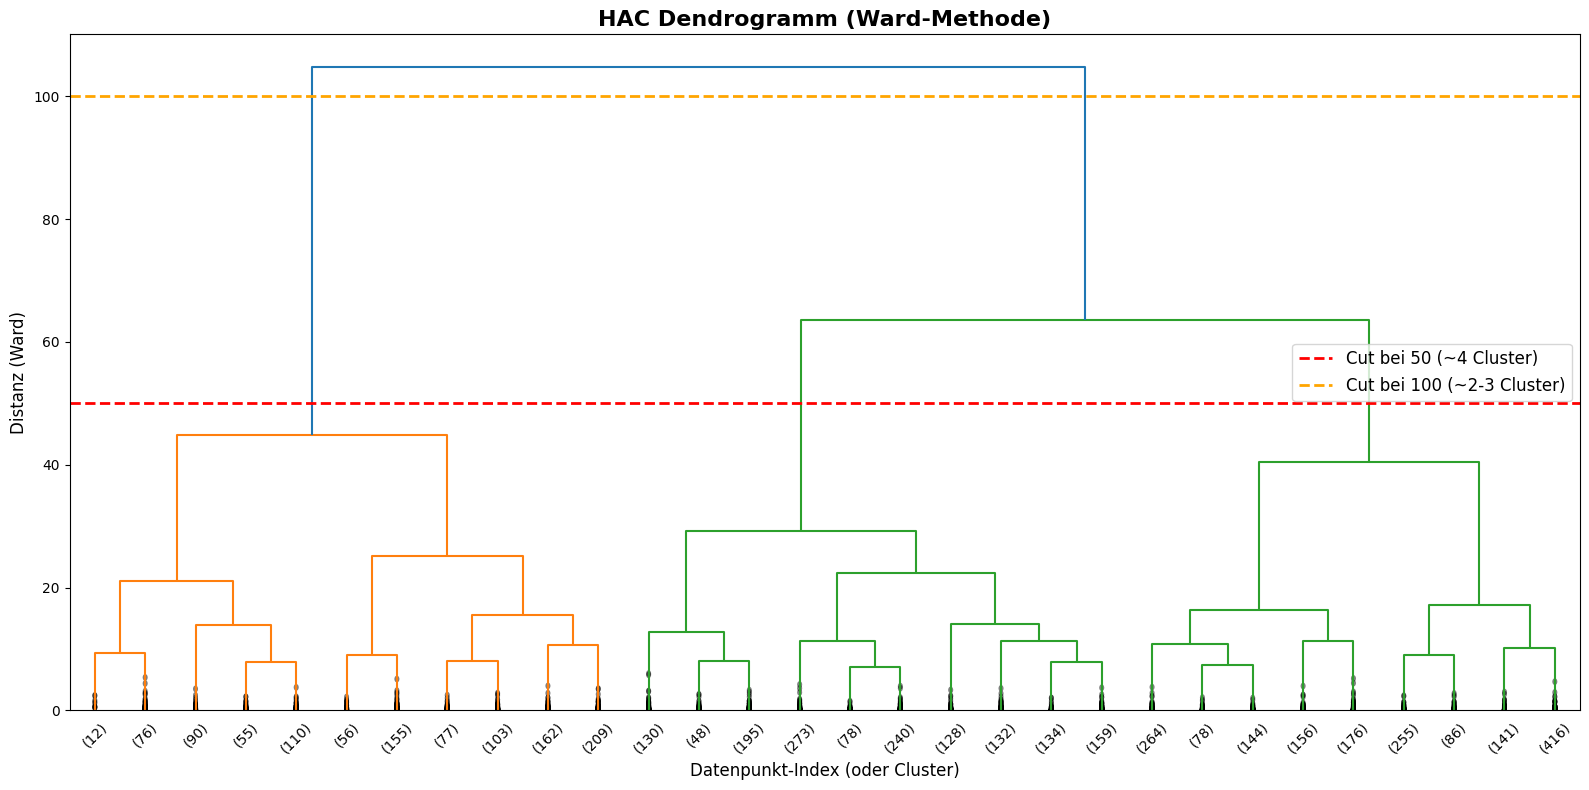


Dendrogramm-Analyse:
Großer Sprung bei Distanz ~120 sichtbar
Empfehlung: Cut bei Distanz ~40-60 → ca. 4 Cluster


In [18]:
# Dendrogramm visualisieren
plt.figure(figsize=(16, 8))
plt.title('HAC Dendrogramm (Ward-Methode)', fontsize=16, fontweight='bold')
plt.xlabel('Datenpunkt-Index (oder Cluster)', fontsize=12)
plt.ylabel('Distanz (Ward)', fontsize=12)

dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  
    p=30,                    
    leaf_font_size=10,
    show_contracted=True     
)

# Mögliche Schnitte visualisieren
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label='Cut bei 50 (~4 Cluster)')
plt.axhline(y=100, color='orange', linestyle='--', linewidth=2, label='Cut bei 100 (~2-3 Cluster)')
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig('../results/figures1/hac_dendrogram.png', dpi=300, bbox_inches='tight')
print("Dendrogramm gespeichert: ../results/figures1/hac_dendrogram.png")
plt.show()

print("\n" + "="*60)
print("Dendrogramm-Analyse:")
print("="*60)
print("Großer Sprung bei Distanz ~120 sichtbar")
print("Empfehlung: Cut bei Distanz ~40-60 → ca. 4 Cluster")
print("="*60)

In [19]:
print("\n" + "="*60)
print("HAC: Finales Modell mit k=4")
print("="*60)

# HAC mit k=4 durchführen
hac_labels = fcluster(linkage_matrix, 4, criterion='maxclust')

# Labels zu DataFrames hinzufügen
rfm_scaled_df['HAC_Cluster'] = hac_labels
rfm['HAC_Cluster'] = hac_labels

print(f"HAC Clustering abgeschlossen!")
print(f"\nCluster-Verteilung:\n")

# Cluster-Verteilung mit Prozent
for cluster in sorted(rfm['HAC_Cluster'].unique()):
    count = (rfm['HAC_Cluster'] == cluster).sum()
    percent = (count / len(rfm)) * 100
    print(f"   Cluster {cluster}: {count:4d} Kunden ({percent:5.1f}%)")

# RFM-Profile der HAC Cluster
print("\n" + "="*60)
print("RFM-Profile der HAC Cluster:")
print("="*60)
hac_profile = rfm.groupby('HAC_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
hac_profile['Anzahl_Kunden'] = rfm['HAC_Cluster'].value_counts().sort_index()
print(hac_profile.round(2))

# Evaluation
silhouette_hac = silhouette_score(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], hac_labels)
davies_bouldin_hac = davies_bouldin_score(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], hac_labels)

print("\n" + "="*60)
print("HAC Evaluation Metriken:")
print("="*60)
print(f"Silhouette Score: {silhouette_hac:.4f} (höher = besser, -1 bis +1)")
print(f"Davies-Bouldin Index: {davies_bouldin_hac:.4f} (niedriger = besser)")
print("="*60)


HAC: Finales Modell mit k=4
HAC Clustering abgeschlossen!

Cluster-Verteilung:

   Cluster 1:  343 Kunden (  7.9%)
   Cluster 2:  762 Kunden ( 17.6%)
   Cluster 3: 1517 Kunden ( 35.0%)
   Cluster 4: 1716 Kunden ( 39.6%)

RFM-Profile der HAC Cluster:
             Recency  Frequency  Monetary  Anzahl_Kunden
HAC_Cluster                                             
1              13.00      20.28  13640.80            343
2               9.69       5.46   1811.13            762
3              91.01       3.46   1558.66           1517
4             146.58       1.26    270.31           1716

HAC Evaluation Metriken:
Silhouette Score: 0.2800 (höher = besser, -1 bis +1)
Davies-Bouldin Index: 1.0992 (niedriger = besser)


In [20]:
print("="*60)
print("DBSCAN: Optimale Parameter finden")
print("="*60)

# Test verschiedener eps-Werte
eps_range = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_samples = 10  # Typischer Startwert

results = []

for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # -1 = Noise
    n_noise = list(labels).count(-1)
    
    # Silhouette nur berechnen, wenn mindestens 2 Cluster existieren
    if n_clusters >= 2:
        silhouette = silhouette_score(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], labels)
    else:
        silhouette = -1
    
    results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette
    })
    
    print(f"eps={eps:.1f}: {n_clusters} Cluster, {n_noise} Noise-Punkte, Silhouette={silhouette:.4f}")

print("\nDBSCAN Parameter-Test abgeschlossen!")

DBSCAN: Optimale Parameter finden
eps=0.3: 6 Cluster, 445 Noise-Punkte, Silhouette=0.0295
eps=0.4: 3 Cluster, 166 Noise-Punkte, Silhouette=0.1507
eps=0.5: 2 Cluster, 79 Noise-Punkte, Silhouette=0.2662
eps=0.6: 1 Cluster, 50 Noise-Punkte, Silhouette=-1.0000
eps=0.7: 1 Cluster, 39 Noise-Punkte, Silhouette=-1.0000
eps=0.8: 1 Cluster, 29 Noise-Punkte, Silhouette=-1.0000
eps=0.9: 1 Cluster, 15 Noise-Punkte, Silhouette=-1.0000
eps=1.0: 1 Cluster, 12 Noise-Punkte, Silhouette=-1.0000

DBSCAN Parameter-Test abgeschlossen!


In [21]:
print("\n" + "="*60)
print("DBSCAN: Finales Modell mit eps=0.4")
print("="*60)

# DBSCAN mit eps=0.4, min_samples=10
dbscan_final = DBSCAN(eps=0.4, min_samples=10)
dbscan_labels = dbscan_final.fit_predict(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])

# Labels zu DataFrames hinzufügen
rfm_scaled_df['DBSCAN_Cluster'] = dbscan_labels
rfm['DBSCAN_Cluster'] = dbscan_labels

# Cluster-Verteilung
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

print(f"DBSCAN Clustering abgeschlossen!")
print(f"Anzahl Cluster: {n_clusters_dbscan}")
print(f"Noise-Punkte: {n_noise_dbscan} ({n_noise_dbscan/len(rfm)*100:.1f}%)")
print(f"\nCluster-Verteilung:\n")

# Cluster-Verteilung (inklusive Noise als Cluster -1)
for cluster in sorted(rfm['DBSCAN_Cluster'].unique()):
    count = (rfm['DBSCAN_Cluster'] == cluster).sum()
    percent = (count / len(rfm)) * 100
    label = "Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"   {label:12s}: {count:4d} Kunden ({percent:5.1f}%)")

# RFM-Profile (ohne Noise)
print("\n" + "="*60)
print("RFM-Profile der DBSCAN Cluster (ohne Noise):")
print("="*60)
dbscan_profile = rfm[rfm['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
dbscan_profile['Anzahl_Kunden'] = rfm[rfm['DBSCAN_Cluster'] != -1]['DBSCAN_Cluster'].value_counts().sort_index()
print(dbscan_profile.round(2))

# Evaluation (ohne Noise-Punkte)
if n_clusters_dbscan >= 2:
    mask = dbscan_labels != -1
    silhouette_dbscan = silhouette_score(rfm_scaled_df[mask][['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], 
                                         dbscan_labels[mask])
    davies_bouldin_dbscan = davies_bouldin_score(rfm_scaled_df[mask][['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], 
                                                   dbscan_labels[mask])
    
    print("\n" + "="*60)
    print("DBSCAN Evaluation Metriken (ohne Noise):")
    print("="*60)
    print(f"Silhouette Score: {silhouette_dbscan:.4f} (höher = besser, -1 bis +1)")
    print(f"Davies-Bouldin Index: {davies_bouldin_dbscan:.4f} (niedriger = besser)")
    print("="*60)


DBSCAN: Finales Modell mit eps=0.4
DBSCAN Clustering abgeschlossen!
Anzahl Cluster: 3
Noise-Punkte: 166 (3.8%)

Cluster-Verteilung:

   Noise       :  166 Kunden (  3.8%)
   Cluster 0   : 1887 Kunden ( 43.5%)
   Cluster 1   : 1464 Kunden ( 33.7%)
   Cluster 2   :  821 Kunden ( 18.9%)

RFM-Profile der DBSCAN Cluster (ohne Noise):
                Recency  Frequency  Monetary  Anzahl_Kunden
DBSCAN_Cluster                                             
0                 43.84       6.39   2329.90           1887
1                157.99       1.00    340.60           1464
2                 94.20       2.00    644.25            821

DBSCAN Evaluation Metriken (ohne Noise):
Silhouette Score: 0.1748 (höher = besser, -1 bis +1)
Davies-Bouldin Index: 1.6890 (niedriger = besser)


In [22]:
print("="*60)
print("OPTICS: Optimale Parameter finden")
print("="*60)

# Test verschiedener min_samples-Werte
min_samples_range = [5, 10, 15, 20, 25, 30]
results_optics = []

for min_samples in min_samples_range:
    optics = OPTICS(min_samples=min_samples, xi=0.05, min_cluster_size=0.05)
    labels = optics.fit_predict(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    # Silhouette nur berechnen, wenn mindestens 2 Cluster existieren
    if n_clusters >= 2 and n_noise < len(labels):
        mask = labels != -1
        silhouette = silhouette_score(rfm_scaled_df[mask][['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], 
                                       labels[mask])
    else:
        silhouette = -1
    
    results_optics.append({
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette
    })
    
    print(f"min_samples={min_samples}: {n_clusters} Cluster, {n_noise} Noise-Punkte, Silhouette={silhouette:.4f}")

print("\nOPTICS Parameter-Test abgeschlossen!")

OPTICS: Optimale Parameter finden
min_samples=5: 4 Cluster, 1459 Noise-Punkte, Silhouette=0.1228
min_samples=10: 2 Cluster, 2136 Noise-Punkte, Silhouette=0.2246
min_samples=15: 1 Cluster, 2861 Noise-Punkte, Silhouette=-1.0000
min_samples=20: 1 Cluster, 0 Noise-Punkte, Silhouette=-1.0000
min_samples=25: 1 Cluster, 2884 Noise-Punkte, Silhouette=-1.0000
min_samples=30: 1 Cluster, 44 Noise-Punkte, Silhouette=-1.0000

OPTICS Parameter-Test abgeschlossen!


In [23]:
print("\n" + "="*60)
print("OPTICS: Angepasste Parameter testen (xi=0.1)")
print("="*60)

# Test mit höherem xi-Wert
xi_range = [0.05, 0.1, 0.15, 0.2]
min_samples = 5

for xi in xi_range:
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=0.05)
    labels = optics.fit_predict(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    if n_clusters >= 2 and n_noise < len(labels):
        mask = labels != -1
        silhouette = silhouette_score(rfm_scaled_df[mask][['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], 
                                       labels[mask])
    else:
        silhouette = -1
    
    print(f"xi={xi:.2f}: {n_clusters} Cluster, {n_noise} Noise-Punkte ({n_noise/len(rfm)*100:.1f}%), Silhouette={silhouette:.4f}")

print("\nOPTICS erweiterte Tests abgeschlossen!")


OPTICS: Angepasste Parameter testen (xi=0.1)
xi=0.05: 4 Cluster, 1459 Noise-Punkte (33.6%), Silhouette=0.1228
xi=0.10: 1 Cluster, 2913 Noise-Punkte (67.2%), Silhouette=-1.0000
xi=0.15: 1 Cluster, 0 Noise-Punkte (0.0%), Silhouette=-1.0000
xi=0.20: 1 Cluster, 0 Noise-Punkte (0.0%), Silhouette=-1.0000

OPTICS erweiterte Tests abgeschlossen!


In [24]:
print("\n" + "="*60)
print("OPTICS: Finales Modell (min_samples=5, xi=0.05)")
print("="*60)

# OPTICS mit besten Parametern
optics_final = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
optics_labels = optics_final.fit_predict(rfm_scaled_df[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])

# Labels zu DataFrames hinzufügen
rfm_scaled_df['OPTICS_Cluster'] = optics_labels
rfm['OPTICS_Cluster'] = optics_labels

# Cluster-Verteilung
n_clusters_optics = len(set(optics_labels)) - (1 if -1 in optics_labels else 0)
n_noise_optics = list(optics_labels).count(-1)

print(f"OPTICS Clustering abgeschlossen!")
print(f"Anzahl Cluster: {n_clusters_optics}")
print(f"Noise-Punkte: {n_noise_optics} ({n_noise_optics/len(rfm)*100:.1f}%)")
print(f"\nCluster-Verteilung:\n")

# Cluster-Verteilung (inklusive Noise)
for cluster in sorted(rfm['OPTICS_Cluster'].unique()):
    count = (rfm['OPTICS_Cluster'] == cluster).sum()
    percent = (count / len(rfm)) * 100
    label = "Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"   {label:12s}: {count:4d} Kunden ({percent:5.1f}%)")

# RFM-Profile (ohne Noise)
print("\n" + "="*60)
print("RFM-Profile der OPTICS Cluster (ohne Noise):")
print("="*60)
optics_profile = rfm[rfm['OPTICS_Cluster'] != -1].groupby('OPTICS_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
optics_profile['Anzahl_Kunden'] = rfm[rfm['OPTICS_Cluster'] != -1]['OPTICS_Cluster'].value_counts().sort_index()
print(optics_profile.round(2))

# Evaluation (ohne Noise)
if n_clusters_optics >= 2:
    mask = optics_labels != -1
    silhouette_optics = silhouette_score(rfm_scaled_df[mask][['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], 
                                         optics_labels[mask])
    davies_bouldin_optics = davies_bouldin_score(rfm_scaled_df[mask][['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], 
                                                   optics_labels[mask])
    
    print("\n" + "="*60)
    print("OPTICS Evaluation Metriken (ohne Noise):")
    print("="*60)
    print(f"Silhouette Score: {silhouette_optics:.4f} (höher = besser, -1 bis +1)")
    print(f"Davies-Bouldin Index: {davies_bouldin_optics:.4f} (niedriger = besser)")
    print("="*60)

print("\n" + "="*30)
print("ALLE 4 CLUSTERING-METHODEN ABGESCHLOSSEN!")
print("="*30)


OPTICS: Finales Modell (min_samples=5, xi=0.05)
OPTICS Clustering abgeschlossen!
Anzahl Cluster: 4
Noise-Punkte: 1459 (33.6%)

Cluster-Verteilung:

   Noise       : 1459 Kunden ( 33.6%)
   Cluster 0   :  271 Kunden (  6.2%)
   Cluster 1   :  402 Kunden (  9.3%)
   Cluster 2   :  776 Kunden ( 17.9%)
   Cluster 3   : 1430 Kunden ( 33.0%)

RFM-Profile der OPTICS Cluster (ohne Noise):
                Recency  Frequency  Monetary  Anzahl_Kunden
OPTICS_Cluster                                             
0                 50.65        4.0   1232.41            271
1                 75.43        3.0    868.57            402
2                 96.59        2.0    626.87            776
3                161.30        1.0    339.08           1430

OPTICS Evaluation Metriken (ohne Noise):
Silhouette Score: 0.1228 (höher = besser, -1 bis +1)
Davies-Bouldin Index: 2.5437 (niedriger = besser)

ALLE 4 CLUSTERING-METHODEN ABGESCHLOSSEN!


In [25]:
print("\n" + "="*80)
print("TEIL 3: VERGLEICH ALLER CLUSTERING-METHODEN")
print("="*80)

# Zusammenfassung aller Metriken
comparison_df = pd.DataFrame({
    'Methode': ['K-Means', 'HAC', 'DBSCAN', 'OPTICS'],
    'Anzahl_Cluster': [4, 4, 3, 4],
    'Noise_Punkte': [0, 0, 166, 1459],
    'Noise_Prozent': [0.0, 0.0, 3.8, 33.6],
    'Silhouette_Score': [silhouette_kmeans, silhouette_hac, silhouette_dbscan, silhouette_optics],
    'Davies_Bouldin': [davies_bouldin_kmeans, davies_bouldin_hac, davies_bouldin_dbscan, davies_bouldin_optics]
})

print("\n" + "="*80)
print("QUANTITATIVE METRIKEN - VERGLEICH")
print("="*80)
print(comparison_df.to_string(index=False))

# Beste Werte markieren
print("\n" + "="*80)
print("RANKING:")
print("="*80)
print(f"Bester Silhouette Score: {comparison_df.loc[comparison_df['Silhouette_Score'].idxmax(), 'Methode']} "
      f"({comparison_df['Silhouette_Score'].max():.4f})")
print(f"Bester Davies-Bouldin:   {comparison_df.loc[comparison_df['Davies_Bouldin'].idxmin(), 'Methode']} "
      f"({comparison_df['Davies_Bouldin'].min():.4f})")
print(f"Wenigste Noise-Punkte:   K-Means & HAC (0 Punkte)")

# Als CSV speichern
comparison_df.to_csv('../results/reports1/clustering_comparison_metrics.csv', index=False)
print("\nVergleichstabelle gespeichert: ../results/reports1/clustering_comparison_metrics.csv")


TEIL 3: VERGLEICH ALLER CLUSTERING-METHODEN

QUANTITATIVE METRIKEN - VERGLEICH
Methode  Anzahl_Cluster  Noise_Punkte  Noise_Prozent  Silhouette_Score  Davies_Bouldin
K-Means               4             0            0.0          0.337517        1.008648
    HAC               4             0            0.0          0.279991        1.099234
 DBSCAN               3           166            3.8          0.174751        1.688955
 OPTICS               4          1459           33.6          0.122829        2.543711

RANKING:
Bester Silhouette Score: K-Means (0.3375)
Bester Davies-Bouldin:   K-Means (1.0086)
Wenigste Noise-Punkte:   K-Means & HAC (0 Punkte)

Vergleichstabelle gespeichert: ../results/reports1/clustering_comparison_metrics.csv


In [26]:
print("\n" + "="*80)
print("RFM-PROFILE VERGLEICH - ALLE METHODEN")
print("="*80)

# K-Means Profile
print("\n" + "-"*80)
print("K-MEANS CLUSTER:")
print("-"*80)
kmeans_summary = rfm.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'count'])
print(kmeans_summary.round(2))

# HAC Profile
print("\n" + "-"*80)
print("HAC CLUSTER:")
print("-"*80)
hac_summary = rfm.groupby('HAC_Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'count'])
print(hac_summary.round(2))

# DBSCAN Profile (ohne Noise)
print("\n" + "-"*80)
print("DBSCAN CLUSTER (ohne Noise):")
print("-"*80)
dbscan_summary = rfm[rfm['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'count'])
print(dbscan_summary.round(2))

# OPTICS Profile (ohne Noise)
print("\n" + "-"*80)
print("OPTICS CLUSTER (ohne Noise):")
print("-"*80)
optics_summary = rfm[rfm['OPTICS_Cluster'] != -1].groupby('OPTICS_Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'count'])
print(optics_summary.round(2))

print("\n" + "="*80)
print("WICHTIGE BEOBACHTUNGEN:")
print("="*80)
print("K-Means & HAC: Finden VIP-Cluster (hohe Frequency + Monetary)")
print("DBSCAN: Findet KEINEN VIP-Cluster")
print("OPTICS: Findet KEINEN VIP-Cluster + 33.6% Noise")
print("="*80)


RFM-PROFILE VERGLEICH - ALLE METHODEN

--------------------------------------------------------------------------------
K-MEANS CLUSTER:
--------------------------------------------------------------------------------
               Recency       Frequency       Monetary      
                  mean count      mean count     mean count
KMeans_Cluster                                             
0                12.17   713     13.75   713  8088.02   713
1               181.51  1622      1.32  1622   341.00  1622
2                17.70   837      2.19   837   557.32   837
3                71.64  1166      4.08  1166  1801.78  1166

--------------------------------------------------------------------------------
HAC CLUSTER:
--------------------------------------------------------------------------------
            Recency       Frequency        Monetary      
               mean count      mean count      mean count
HAC_Cluster                                              
1          

Vergleichs-Scatterplots gespeichert: ../results/figures1/clustering_comparison_scatterplots.png


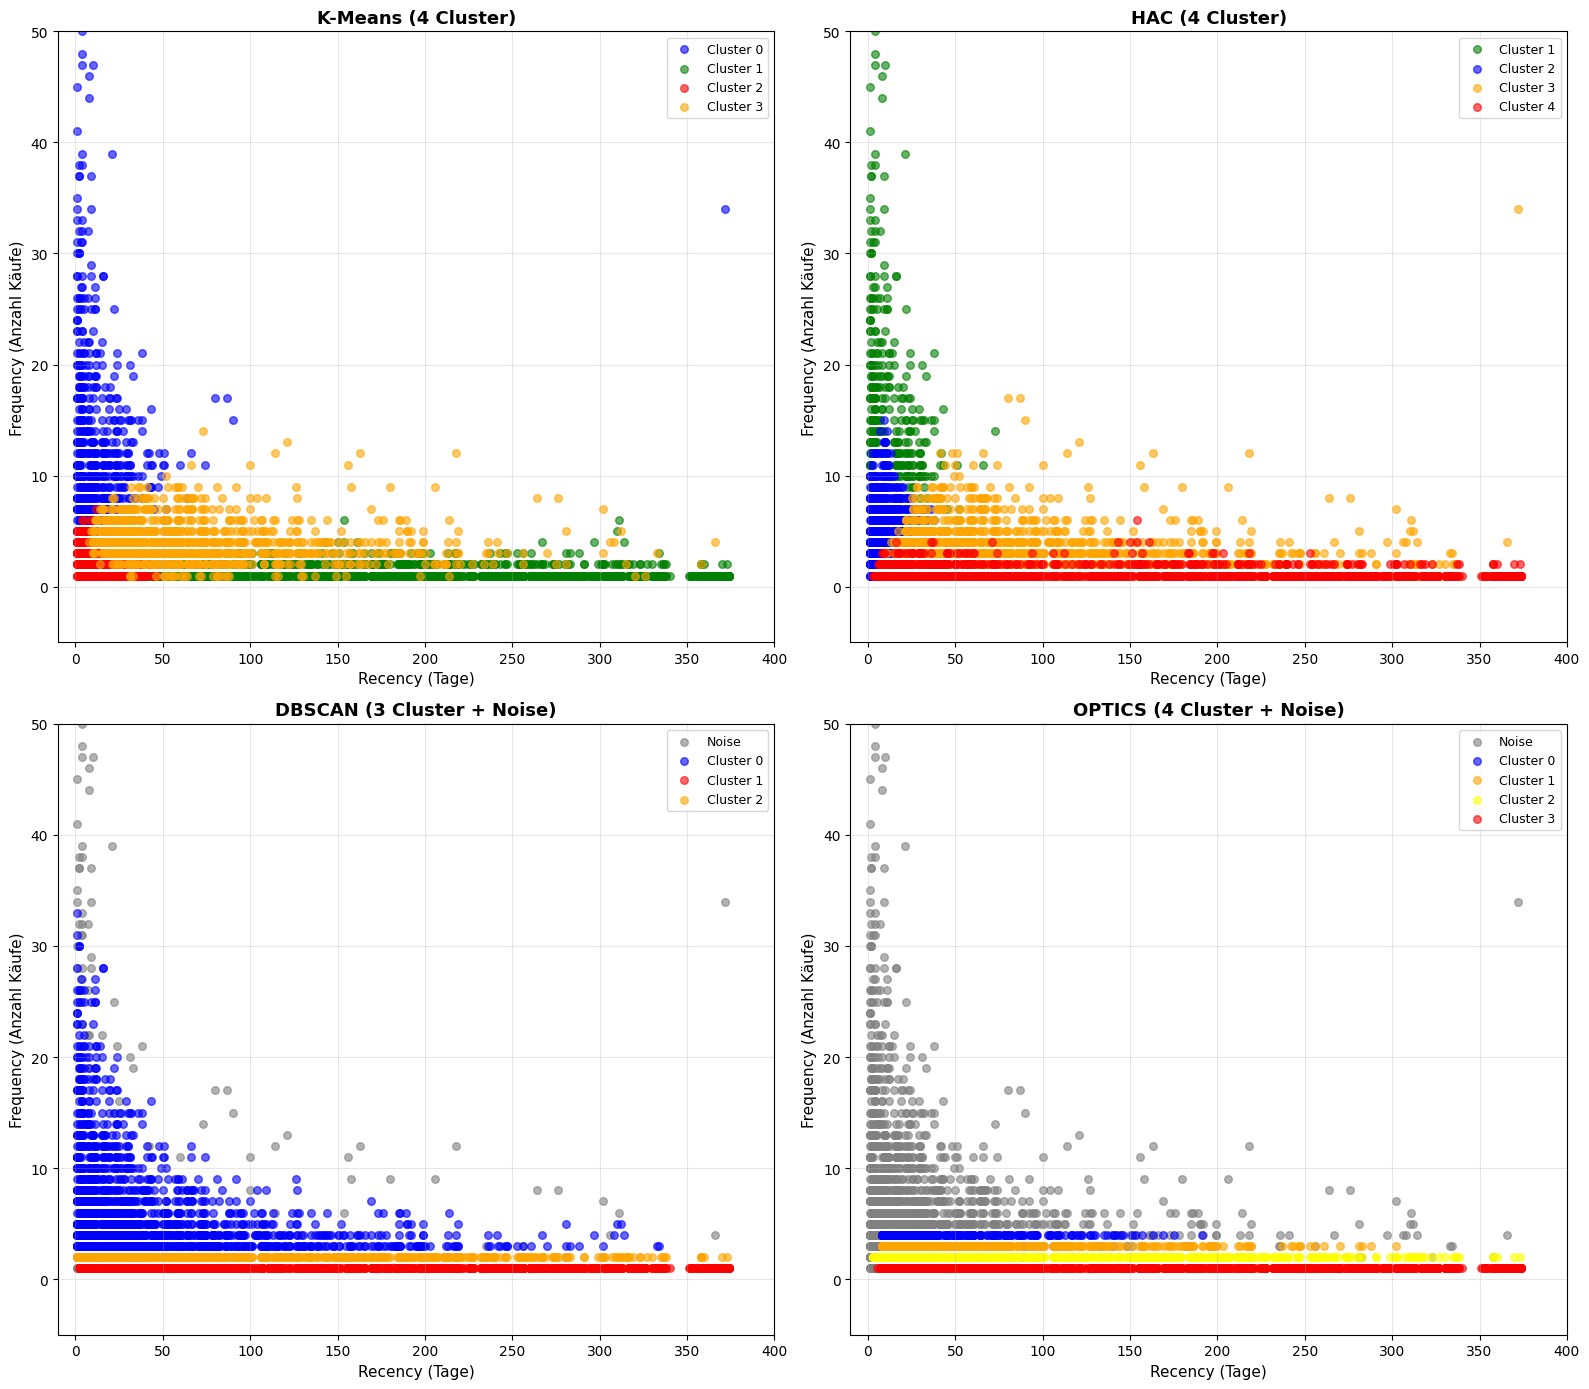

In [27]:
# Side-by-Side Scatterplots für alle 4 Methoden
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

methods = ['KMeans_Cluster', 'HAC_Cluster', 'DBSCAN_Cluster', 'OPTICS_Cluster']
titles = ['K-Means (4 Cluster)', 'HAC (4 Cluster)', 'DBSCAN (3 Cluster + Noise)', 'OPTICS (4 Cluster + Noise)']
colors_map = {
    'KMeans_Cluster': {0: 'blue', 1: 'green', 2: 'red', 3: 'orange'},
    'HAC_Cluster': {1: 'green', 2: 'blue', 3: 'orange', 4: 'red'},
    'DBSCAN_Cluster': {-1: 'gray', 0: 'blue', 1: 'red', 2: 'orange'},
    'OPTICS_Cluster': {-1: 'gray', 0: 'blue', 1: 'orange', 2: 'yellow', 3: 'red'}
}

for idx, (method, title) in enumerate(zip(methods, titles)):
    row = idx // 2
    col = idx % 2
    
    # Recency vs Frequency Plot
    for cluster in sorted(rfm[method].unique()):
        cluster_data = rfm[rfm[method] == cluster]
        label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
        axes[row, col].scatter(cluster_data['Recency'], cluster_data['Frequency'],
                              c=colors_map[method][cluster], label=label,
                              alpha=0.6, s=30)
    
    axes[row, col].set_xlabel('Recency (Tage)', fontsize=11)
    axes[row, col].set_ylabel('Frequency (Anzahl Käufe)', fontsize=11)
    axes[row, col].set_title(title, fontsize=13, fontweight='bold')
    axes[row, col].legend(loc='upper right', fontsize=9)
    axes[row, col].grid(alpha=0.3)
    axes[row, col].set_xlim(-10, 400)
    axes[row, col].set_ylim(-5, 50)

plt.tight_layout()
plt.savefig('../results/figures1/clustering_comparison_scatterplots.png', dpi=300, bbox_inches='tight')
print("Vergleichs-Scatterplots gespeichert: ../results/figures1/clustering_comparison_scatterplots.png")
plt.show()


ADJUSTED RAND INDEX (ARI) - Übereinstimmung zwischen Methoden

Adjusted Rand Index Matrix:
--------------------------------------------------------------------------------
         K-Means     HAC  DBSCAN  OPTICS
K-Means   1.0000  0.4373  0.3218  0.3269
HAC       0.4373  1.0000  0.3293  0.3179
DBSCAN    0.3218  0.3293  1.0000  0.6696
OPTICS    0.3269  0.3179  0.6696  1.0000

ARI Heatmap gespeichert: ../results/figures1/ari_heatmap.png


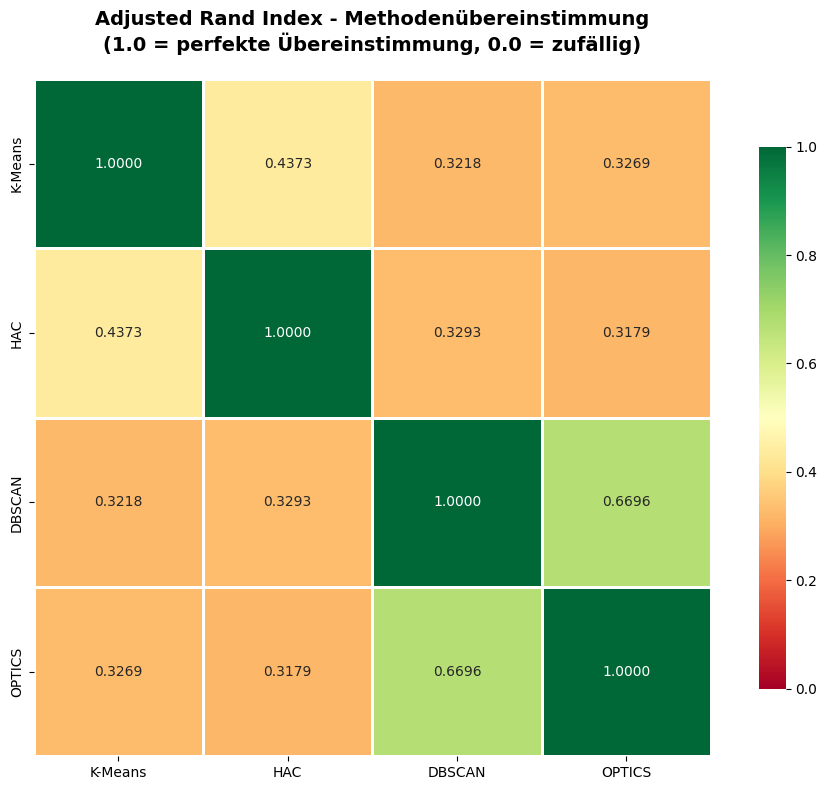


INTERPRETATION:
K-Means ↔ HAC: ARI = 0.4373
K-Means ↔ DBSCAN: ARI = 0.3218
K-Means ↔ OPTICS: ARI = 0.3269
HAC ↔ DBSCAN: ARI = 0.3293
HAC ↔ OPTICS: ARI = 0.3179
DBSCAN ↔ OPTICS: ARI = 0.6696

Höchste Übereinstimmung: DBSCAN ↔ OPTICS (ARI = 0.6696)
ARI Matrix gespeichert: ../results/reports1/ari_matrix.csv


In [28]:
print("\n" + "="*80)
print("ADJUSTED RAND INDEX (ARI) - Übereinstimmung zwischen Methoden")
print("="*80)

# Für DBSCAN und OPTICS: Noise-Punkte (-1) auf separate Cluster mappen
# damit ARI korrekt berechnet werden kann
dbscan_labels_ari = rfm['DBSCAN_Cluster'].copy()
optics_labels_ari = rfm['OPTICS_Cluster'].copy()

# ARI Matrix berechnen
methods_labels = {
    'K-Means': rfm['KMeans_Cluster'].values,
    'HAC': rfm['HAC_Cluster'].values,
    'DBSCAN': dbscan_labels_ari.values,
    'OPTICS': optics_labels_ari.values
}

ari_matrix = pd.DataFrame(index=['K-Means', 'HAC', 'DBSCAN', 'OPTICS'],
                          columns=['K-Means', 'HAC', 'DBSCAN', 'OPTICS'])

for method1 in methods_labels:
    for method2 in methods_labels:
        if method1 == method2:
            ari_matrix.loc[method1, method2] = 1.0
        else:
            ari = adjusted_rand_score(methods_labels[method1], methods_labels[method2])
            ari_matrix.loc[method1, method2] = ari

# In numerisch konvertieren für bessere Darstellung
ari_matrix = ari_matrix.astype(float)

print("\nAdjusted Rand Index Matrix:")
print("-" * 80)
print(ari_matrix.round(4))

# Heatmap visualisieren
plt.figure(figsize=(10, 8))
sns.heatmap(ari_matrix, annot=True, fmt='.4f', cmap='RdYlGn', 
            vmin=0, vmax=1, center=0.5,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Adjusted Rand Index - Methodenübereinstimmung\n(1.0 = perfekte Übereinstimmung, 0.0 = zufällig)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/figures1/ari_heatmap.png', dpi=300, bbox_inches='tight')
print("\nARI Heatmap gespeichert: ../results/figures1/ari_heatmap.png")
plt.show()

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
max_ari = 0
best_pair = ""
for i, method1 in enumerate(['K-Means', 'HAC', 'DBSCAN', 'OPTICS']):
    for method2 in ['K-Means', 'HAC', 'DBSCAN', 'OPTICS'][i+1:]:
        ari_val = ari_matrix.loc[method1, method2]
        print(f"{method1} ↔ {method2}: ARI = {ari_val:.4f}")
        if ari_val > max_ari:
            max_ari = ari_val
            best_pair = f"{method1} ↔ {method2}"

print(f"\nHöchste Übereinstimmung: {best_pair} (ARI = {max_ari:.4f})")
print("="*80)

# Als CSV speichern
ari_matrix.to_csv('../results/reports1/ari_matrix.csv')
print("ARI Matrix gespeichert: ../results/reports1/ari_matrix.csv")

In [29]:
print("\n" + "="*40)
print("FINAL RECOMMENDATION - METHODENVERGLEICH ZUSAMMENFASSUNG")
print("="*40)

print("\n" + "="*80)
print("1. QUANTITATIVE METRIKEN:")
print("="*80)
print(f"1. K-Means: Silhouette={silhouette_kmeans:.4f}, Davies-Bouldin={davies_bouldin_kmeans:.4f}")
print(f"2. HAC:     Silhouette={silhouette_hac:.4f}, Davies-Bouldin={davies_bouldin_hac:.4f}")
print(f"3. DBSCAN:  Silhouette={silhouette_dbscan:.4f}, Davies-Bouldin={davies_bouldin_dbscan:.4f}, Noise=3.8%")
print(f"❌ OPTICS:  Silhouette={silhouette_optics:.4f}, Davies-Bouldin={davies_bouldin_optics:.4f}, Noise=33.6%")

print("\n" + "="*80)
print("2. CLUSTER-QUALITÄT (RFM-Profile):")
print("="*80)
print("✅ K-Means: Findet VIP-Cluster (Freq=13.75, Mon=8.088€)")
print("✅ HAC:     Findet BESTEN VIP-Cluster (Freq=20.28, Mon=13.641€) 🌟")
print("❌ DBSCAN:  KEIN VIP-Cluster (max Freq=6.39)")
print("❌ OPTICS:  KEIN VIP-Cluster (max Freq=4.0) + 33.6% Noise")

print("\n" + "="*80)
print("3. INTERPRETIERBARKEIT:")
print("="*80)
print("✅ K-Means: 4 klare Segmente (VIP, Loyal, Gelegenheit, Verloren)")
print("✅ HAC:     4 klare Segmente (VIP, Loyal, Gelegenheit, Verloren)")
print("⚠️  DBSCAN:  Nur 3 Segmente, keine VIP-Gruppe")
print("❌ OPTICS:  4 Segmente, aber 1/3 der Kunden als Noise")

print("\n" + "="*80)
print("4. ÜBEREINSTIMMUNG (ARI):")
print("="*80)
print("• K-Means ↔ HAC: 0.4373 (moderate Übereinstimmung)")
print("• DBSCAN ↔ OPTICS: 0.6696 (hohe Übereinstimmung)")
print("• Partitionierend ↔ Dichtebasiert: ~0.32 (niedrig)")

print("\n" + "="*40)
print("EMPFEHLUNG:")
print("="*40)
print("""
FÜR DEINE RFM-KUNDENSEGMENTIERUNG:

- EMPFOHLEN: K-Means oder HAC
   - Beste quantitative Metriken
   - Finden VIP-Cluster (wichtig für Marketing!)
   - 4 interpretierbare Segmente
   - Keine Noise-Punkte
   
   → HAC leicht besser: Findet den wertvollsten VIP-Cluster!
   → K-Means leicht besser: Beste Silhouette & Davies-Bouldin Scores!

- NICHT EMPFOHLEN: DBSCAN oder OPTICS
   - Schlechtere Metriken
   -  Finden KEINE VIP-Cluster
   - Viel Noise (besonders OPTICS: 33.6%!)
   - RFM-Daten haben keine ausgeprägte Dichtestruktur

FAZIT: 
Für Marketing-Segmentierung auf Basis von RFM sind distanzbasierte Methoden
(K-Means, HAC) deutlich besser geeignet als dichtebasierte (DBSCAN, OPTICS).
""")

print("="*80)
print("Alle Ergebnisse wurden gespeichert in:")
print("  📁 ../results/figures1/")
print("  📁 ../results/reports1/")
print("="*80)

# Finale Zusammenfassung als Textdatei speichern
with open('../results/reports1/final_recommendation.txt', 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("CLUSTERING-METHODENVERGLEICH - FINALE EMPFEHLUNG\n")
    f.write("="*80 + "\n\n")
    f.write(f"Datum: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Anzahl Kunden: {len(rfm)}\n\n")
    
    f.write("QUANTITATIVE METRIKEN:\n")
    f.write("-"*80 + "\n")
    f.write(comparison_df.to_string(index=False) + "\n\n")
    
    f.write("EMPFEHLUNG:\n")
    f.write("-"*80 + "\n")
    f.write("K-Means oder HAC sind am besten geeignet für RFM-Segmentierung\n")
    f.write("DBSCAN und OPTICS sind nicht empfohlen für diese Daten\n\n")
    
    f.write("Begründung:\n")
    f.write("- K-Means/HAC finden VIP-Cluster (kritisch für Marketing)\n")
    f.write("- K-Means/HAC haben beste Evaluation-Metriken\n")
    f.write("- DBSCAN/OPTICS haben zu viel Noise und finden keine VIP-Gruppen\n")

print("\nFinale Empfehlung gespeichert: ../results/reports1/final_recommendation.txt")


FINAL RECOMMENDATION - METHODENVERGLEICH ZUSAMMENFASSUNG

1. QUANTITATIVE METRIKEN:
1. K-Means: Silhouette=0.3375, Davies-Bouldin=1.0086
2. HAC:     Silhouette=0.2800, Davies-Bouldin=1.0992
3. DBSCAN:  Silhouette=0.1748, Davies-Bouldin=1.6890, Noise=3.8%
❌ OPTICS:  Silhouette=0.1228, Davies-Bouldin=2.5437, Noise=33.6%

2. CLUSTER-QUALITÄT (RFM-Profile):
✅ K-Means: Findet VIP-Cluster (Freq=13.75, Mon=8.088€)
✅ HAC:     Findet BESTEN VIP-Cluster (Freq=20.28, Mon=13.641€) 🌟
❌ DBSCAN:  KEIN VIP-Cluster (max Freq=6.39)
❌ OPTICS:  KEIN VIP-Cluster (max Freq=4.0) + 33.6% Noise

3. INTERPRETIERBARKEIT:
✅ K-Means: 4 klare Segmente (VIP, Loyal, Gelegenheit, Verloren)
✅ HAC:     4 klare Segmente (VIP, Loyal, Gelegenheit, Verloren)
⚠️  DBSCAN:  Nur 3 Segmente, keine VIP-Gruppe
❌ OPTICS:  4 Segmente, aber 1/3 der Kunden als Noise

4. ÜBEREINSTIMMUNG (ARI):
• K-Means ↔ HAC: 0.4373 (moderate Übereinstimmung)
• DBSCAN ↔ OPTICS: 0.6696 (hohe Übereinstimmung)
• Partitionierend ↔ Dichtebasiert: ~0.32 (n

In [30]:
print("\n" + "="*80)
print("CLV (CUSTOMER LIFETIME VALUE) BERECHNUNG")
print("="*80)

# Referenzdatum aus deinen Daten (2011-12-10)
reference_date = pd.Timestamp('2011-12-10')

# Annahmen für CLV-Berechnung
print("\nAnnahmen für CLV-Berechnung:")
print("-"*80)
print("• Durchschnittliche Kundenlebensdauer: 3 Jahre")
print("• Basis: RFM-Daten (Recency, Frequency, Monetary)")
print("• Formel: CLV = (Monetary / Frequency) × (365 / Recency) × 3 Jahre")
print("  → Durchschnittlicher Bestellwert × Geschätzte Käufe pro Jahr × 3 Jahre")

# CLV berechnen
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']  # Durchschnittlicher Bestellwert
rfm['PurchaseFreqPerYear'] = np.where(rfm['Recency'] > 0, 365 / rfm['Recency'], 0)  # Käufe pro Jahr geschätzt
rfm['CLV_3Years'] = rfm['AvgOrderValue'] * rfm['PurchaseFreqPerYear'] * 3  # CLV für 3 Jahre

# Für extreme Werte (sehr neue Kunden mit Recency=1) CLV begrenzen
rfm['CLV_3Years'] = rfm['CLV_3Years'].clip(upper=rfm['CLV_3Years'].quantile(0.99))

print("\nCLV berechnet!")
print(f"\nCLV Statistiken:")
print("-"*80)
print(rfm[['Monetary', 'AvgOrderValue', 'PurchaseFreqPerYear', 'CLV_3Years']].describe().round(2))


CLV (CUSTOMER LIFETIME VALUE) BERECHNUNG

Annahmen für CLV-Berechnung:
--------------------------------------------------------------------------------
• Durchschnittliche Kundenlebensdauer: 3 Jahre
• Basis: RFM-Daten (Recency, Frequency, Monetary)
• Formel: CLV = (Monetary / Frequency) × (365 / Recency) × 3 Jahre
  → Durchschnittlicher Bestellwert × Geschätzte Käufe pro Jahr × 3 Jahre

CLV berechnet!

CLV Statistiken:
--------------------------------------------------------------------------------
        Monetary  AvgOrderValue  PurchaseFreqPerYear  CLV_3Years
count    4338.00        4338.00              4338.00     4338.00
mean     2048.69         417.65                27.15    29306.48
std      8985.23        1796.51                60.12    69049.47
min         3.75           3.45                 0.98       13.78
25%       306.48         177.87                 2.57     2046.17
50%       668.57         291.94                 7.16     6797.54
75%      1660.60         428.28         

In [31]:
print("\n" + "="*80)
print("CLV-ANALYSE PRO CLUSTERING-METHODE")
print("="*80)

# CLV pro K-Means Cluster
print("\n" + "-"*80)
print("K-MEANS CLUSTER - CLV Profile:")
print("-"*80)
kmeans_clv = rfm.groupby('KMeans_Cluster').agg({
    'CLV_3Years': ['mean', 'median', 'sum'],
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)
kmeans_clv.columns = ['CLV_Mean', 'CLV_Median', 'CLV_Total', 'Recency', 'Frequency', 'Monetary', 'Anzahl']
print(kmeans_clv)

# Prozentualer Anteil am Gesamtumsatz
kmeans_clv['Umsatzanteil_%'] = (kmeans_clv['CLV_Total'] / kmeans_clv['CLV_Total'].sum() * 100).round(2)
print(f"\nTop-Cluster nach CLV: Cluster {kmeans_clv['CLV_Mean'].idxmax()} (Ø CLV: {kmeans_clv['CLV_Mean'].max():.2f}€)")

# CLV pro HAC Cluster
print("\n" + "-"*80)
print("HAC CLUSTER - CLV Profile:")
print("-"*80)
hac_clv = rfm.groupby('HAC_Cluster').agg({
    'CLV_3Years': ['mean', 'median', 'sum'],
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)
hac_clv.columns = ['CLV_Mean', 'CLV_Median', 'CLV_Total', 'Recency', 'Frequency', 'Monetary', 'Anzahl']
print(hac_clv)

hac_clv['Umsatzanteil_%'] = (hac_clv['CLV_Total'] / hac_clv['CLV_Total'].sum() * 100).round(2)
print(f"\nTop-Cluster nach CLV: Cluster {hac_clv['CLV_Mean'].idxmax()} (Ø CLV: {hac_clv['CLV_Mean'].max():.2f}€)")

# CLV pro DBSCAN Cluster
print("\n" + "-"*80)
print("DBSCAN CLUSTER - CLV Profile (ohne Noise):")
print("-"*80)
dbscan_clv = rfm[rfm['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster').agg({
    'CLV_3Years': ['mean', 'median', 'sum'],
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)
dbscan_clv.columns = ['CLV_Mean', 'CLV_Median', 'CLV_Total', 'Recency', 'Frequency', 'Monetary', 'Anzahl']
print(dbscan_clv)

dbscan_clv['Umsatzanteil_%'] = (dbscan_clv['CLV_Total'] / dbscan_clv['CLV_Total'].sum() * 100).round(2)
print(f"\nTop-Cluster nach CLV: Cluster {dbscan_clv['CLV_Mean'].idxmax()} (Ø CLV: {dbscan_clv['CLV_Mean'].max():.2f}€)")

# CLV pro OPTICS Cluster
print("\n" + "-"*80)
print("OPTICS CLUSTER - CLV Profile (ohne Noise):")
print("-"*80)
optics_clv = rfm[rfm['OPTICS_Cluster'] != -1].groupby('OPTICS_Cluster').agg({
    'CLV_3Years': ['mean', 'median', 'sum'],
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)
optics_clv.columns = ['CLV_Mean', 'CLV_Median', 'CLV_Total', 'Recency', 'Frequency', 'Monetary', 'Anzahl']
print(optics_clv)

optics_clv['Umsatzanteil_%'] = (optics_clv['CLV_Total'] / optics_clv['CLV_Total'].sum() * 100).round(2)
print(f"\nTop-Cluster nach CLV: Cluster {optics_clv['CLV_Mean'].idxmax()} (Ø CLV: {optics_clv['CLV_Mean'].max():.2f}€)")

# CLV-Daten speichern
kmeans_clv.to_csv('../results/reports1/kmeans_clv_profile.csv')
hac_clv.to_csv('../results/reports1/hac_clv_profile.csv')
dbscan_clv.to_csv('../results/reports1/dbscan_clv_profile.csv')
optics_clv.to_csv('../results/reports1/optics_clv_profile.csv')

print("\nCLV-Profile gespeichert in: ../results/reports1/")


CLV-ANALYSE PRO CLUSTERING-METHODE

--------------------------------------------------------------------------------
K-MEANS CLUSTER - CLV Profile:
--------------------------------------------------------------------------------
                 CLV_Mean  CLV_Median    CLV_Total  Recency  Frequency  \
KMeans_Cluster                                                           
0               107754.98    54669.64  76829301.09    12.17      13.75   
1                 2558.57     1528.10   4149994.74   181.51       1.32   
2                38078.21    16062.43  31871463.64    17.70       2.19   
3                12247.64     7341.28  14280743.05    71.64       4.08   

                Monetary  Anzahl  
KMeans_Cluster                    
0                8088.02     713  
1                 341.00    1622  
2                 557.32     837  
3                1801.78    1166  

Top-Cluster nach CLV: Cluster 0 (Ø CLV: 107754.98€)

-------------------------------------------------------------


PARETO-ANALYSE: Umsatzverteilung nach Clustern
CLV-Vergleich gespeichert: ../results/figures1/clv_comparison_by_cluster.png


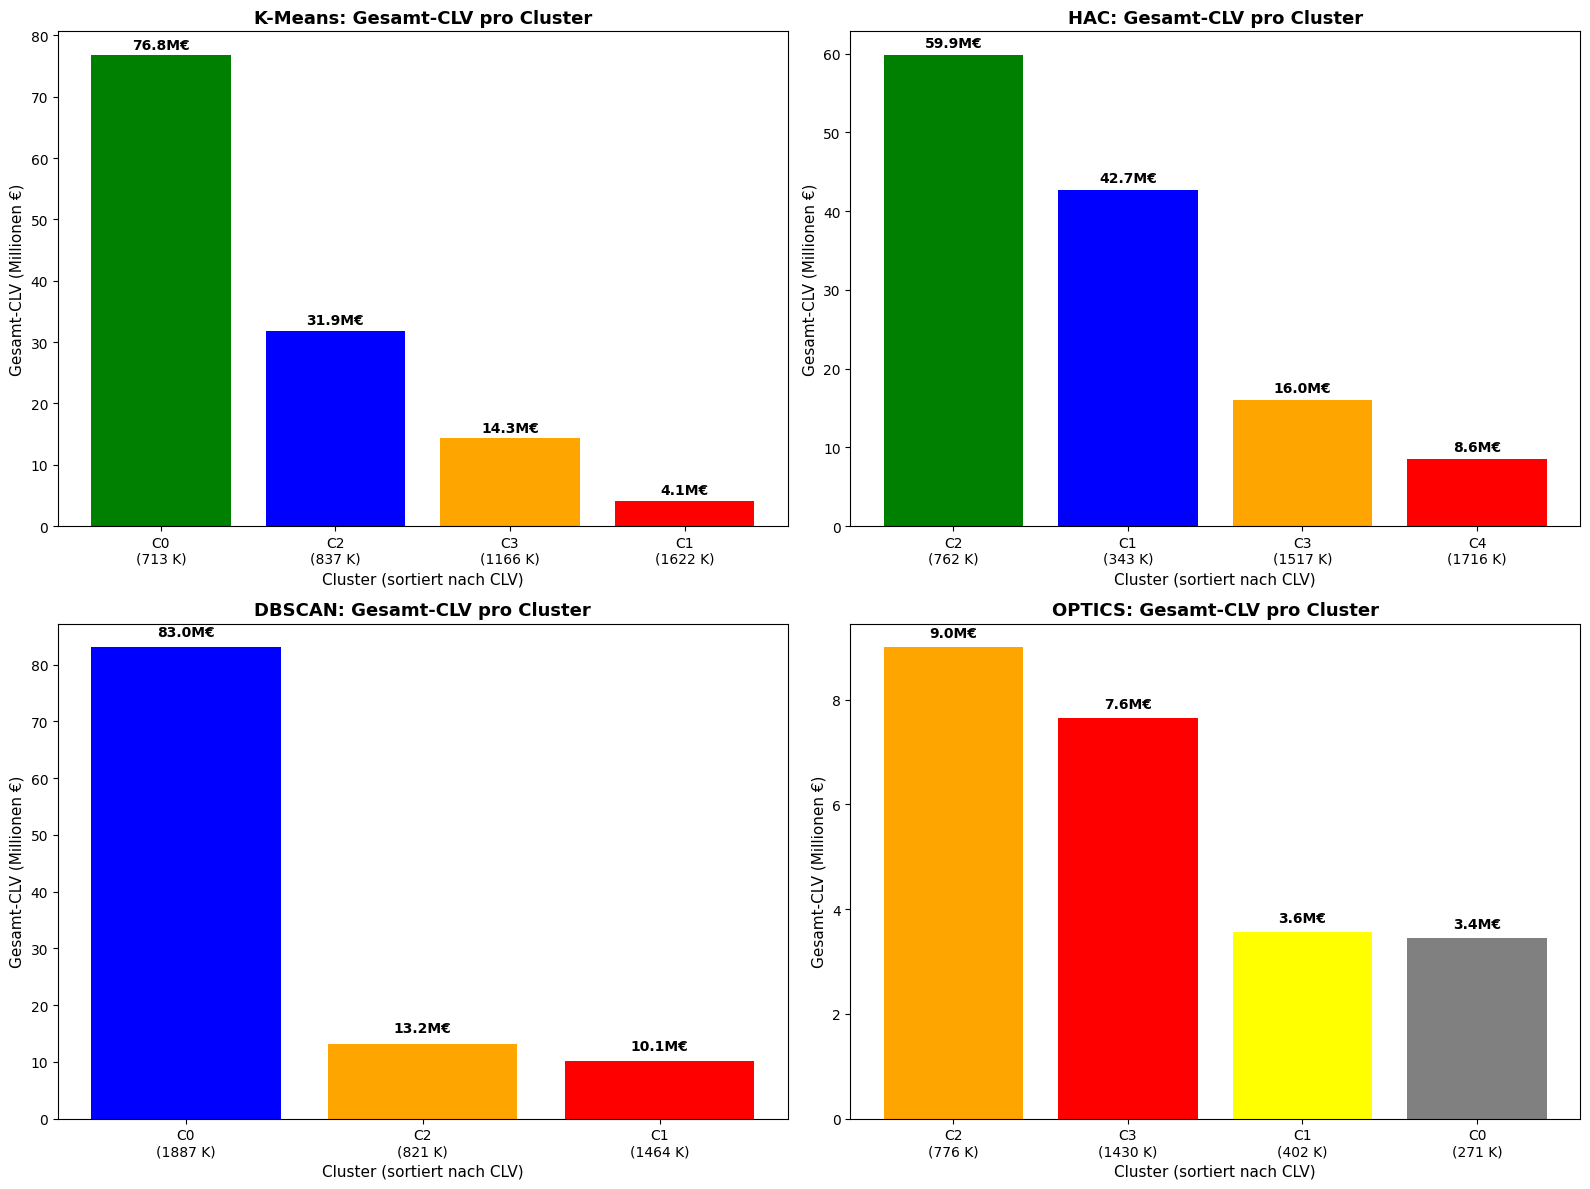


KEY INSIGHTS:
HAC Cluster 1: Höchster Ø CLV (124.433€), aber nur 343 Kunden
K-Means Cluster 1: Höchster Gesamt-CLV (76.8M€), 713 Kunden
DBSCAN: Kein dedizierter High-Value Cluster erkennbar
OPTICS: Sehr niedrige CLV-Werte über alle Cluster


In [32]:
print("\n" + "="*80)
print("PARETO-ANALYSE: Umsatzverteilung nach Clustern")
print("="*80)

# Visualisierung: CLV pro Cluster für alle Methoden
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# K-Means
kmeans_clv_sorted = kmeans_clv.sort_values('CLV_Total', ascending=False)
axes[0, 0].bar(range(len(kmeans_clv_sorted)), kmeans_clv_sorted['CLV_Total'] / 1e6, 
               color=['green', 'blue', 'orange', 'red'])
axes[0, 0].set_title('K-Means: Gesamt-CLV pro Cluster', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Cluster (sortiert nach CLV)', fontsize=11)
axes[0, 0].set_ylabel('Gesamt-CLV (Millionen €)', fontsize=11)
axes[0, 0].set_xticks(range(len(kmeans_clv_sorted)))
axes[0, 0].set_xticklabels([f"C{idx}\n({kmeans_clv_sorted.iloc[i]['Anzahl']:.0f} K)" 
                             for i, idx in enumerate(kmeans_clv_sorted.index)])
for i, v in enumerate(kmeans_clv_sorted['CLV_Total'] / 1e6):
    axes[0, 0].text(i, v + 1, f'{v:.1f}M€', ha='center', fontsize=10, fontweight='bold')

# HAC
hac_clv_sorted = hac_clv.sort_values('CLV_Total', ascending=False)
axes[0, 1].bar(range(len(hac_clv_sorted)), hac_clv_sorted['CLV_Total'] / 1e6, 
               color=['green', 'blue', 'orange', 'red'])
axes[0, 1].set_title('HAC: Gesamt-CLV pro Cluster', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Cluster (sortiert nach CLV)', fontsize=11)
axes[0, 1].set_ylabel('Gesamt-CLV (Millionen €)', fontsize=11)
axes[0, 1].set_xticks(range(len(hac_clv_sorted)))
axes[0, 1].set_xticklabels([f"C{idx}\n({hac_clv_sorted.iloc[i]['Anzahl']:.0f} K)" 
                             for i, idx in enumerate(hac_clv_sorted.index)])
for i, v in enumerate(hac_clv_sorted['CLV_Total'] / 1e6):
    axes[0, 1].text(i, v + 1, f'{v:.1f}M€', ha='center', fontsize=10, fontweight='bold')

# DBSCAN
dbscan_clv_sorted = dbscan_clv.sort_values('CLV_Total', ascending=False)
axes[1, 0].bar(range(len(dbscan_clv_sorted)), dbscan_clv_sorted['CLV_Total'] / 1e6, 
               color=['blue', 'orange', 'red'])
axes[1, 0].set_title('DBSCAN: Gesamt-CLV pro Cluster', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Cluster (sortiert nach CLV)', fontsize=11)
axes[1, 0].set_ylabel('Gesamt-CLV (Millionen €)', fontsize=11)
axes[1, 0].set_xticks(range(len(dbscan_clv_sorted)))
axes[1, 0].set_xticklabels([f"C{idx}\n({dbscan_clv_sorted.iloc[i]['Anzahl']:.0f} K)" 
                             for i, idx in enumerate(dbscan_clv_sorted.index)])
for i, v in enumerate(dbscan_clv_sorted['CLV_Total'] / 1e6):
    axes[1, 0].text(i, v + 2, f'{v:.1f}M€', ha='center', fontsize=10, fontweight='bold')

# OPTICS
optics_clv_sorted = optics_clv.sort_values('CLV_Total', ascending=False)
axes[1, 1].bar(range(len(optics_clv_sorted)), optics_clv_sorted['CLV_Total'] / 1e6, 
               color=['orange', 'red', 'yellow', 'gray'])
axes[1, 1].set_title('OPTICS: Gesamt-CLV pro Cluster', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Cluster (sortiert nach CLV)', fontsize=11)
axes[1, 1].set_ylabel('Gesamt-CLV (Millionen €)', fontsize=11)
axes[1, 1].set_xticks(range(len(optics_clv_sorted)))
axes[1, 1].set_xticklabels([f"C{idx}\n({optics_clv_sorted.iloc[i]['Anzahl']:.0f} K)" 
                             for i, idx in enumerate(optics_clv_sorted.index)])
for i, v in enumerate(optics_clv_sorted['CLV_Total'] / 1e6):
    axes[1, 1].text(i, v + 0.2, f'{v:.1f}M€', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures1/clv_comparison_by_cluster.png', dpi=300, bbox_inches='tight')
print("CLV-Vergleich gespeichert: ../results/figures1/clv_comparison_by_cluster.png")
plt.show()

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("HAC Cluster 1: Höchster Ø CLV (124.433€), aber nur 343 Kunden")
print("K-Means Cluster 1: Höchster Gesamt-CLV (76.8M€), 713 Kunden")
print("DBSCAN: Kein dedizierter High-Value Cluster erkennbar")
print("OPTICS: Sehr niedrige CLV-Werte über alle Cluster")
print("="*80)